### реализую метрику CVNN (Оценивает разделение на основе геометрического расположения точек в кластерах, используя динамические представления для различных кластеров)

In [ ]:
import numpy as np
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors

class CVNNValidator:
    def __init__(self, k_neighbors=5):
        self.k = max(1, k_neighbors)  # Гарантируем хотя бы 1 соседа

    def compute_index(self, data, labels):
        unique_labels, counts = np.unique(labels, return_counts=True)
        n_clusters = len(unique_labels)

        # Краевые случаи
        if n_clusters == 1 or len(data) < 2:
            return float('inf')

        # Отсеиваем шумовые точки (метка -1)
        valid_mask = labels != -1
        data = data[valid_mask]
        labels = labels[valid_mask]

        total_compactness = 0.0
        total_separability = 0.0
        valid_clusters = 0

        for label in unique_labels:
            if label == -1:
                continue

            cluster_points = data[labels == label]
            other_points = data[labels != label]

            if len(cluster_points) < 2:
                continue

            # Компактность
            pairwise_dist = distance.pdist(cluster_points)
            compactness = np.mean(pairwise_dist)

            # Разделимость
            if len(other_points) > 0:
                n_neighbors = min(self.k, len(other_points))
                nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(other_points)
                distances, _ = nbrs.kneighbors(cluster_points)
                separability = np.mean(distances)
            else:
                separability = 0.0

            total_compactness += compactness
            total_separability += separability
            valid_clusters += 1

        if valid_clusters == 0 or total_separability == 0:
            return float('inf')

        # Финальная формула
        raw_score = (total_compactness / valid_clusters) / (total_separability / valid_clusters)
        return 1 - np.exp(-raw_score)

### метрика s_dbw

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

def S_Dbw(X, labels, centers=None, k_neighbors=5):
    """
    Вычисляет Score Density-based (S_Dbw) для оценки кластеризации.

    Параметры:
        X : array-like, shape (n_samples, n_features)
            Входные данные.
        labels : array-like, shape (n_samples,)
            Метки кластеров.
        centers : array-like, shape (n_clusters, n_features), optional
            Центры кластеров. Если None, будут вычислены как средние.
        k_neighbors : int, optional
            Количество соседей для оценки плотности.

    Возвращает:
        s_dbw : float
            Значение метрики S_Dbw (чем меньше, тем лучше).
    """
    # Проверка входных данных
    if len(X) != len(labels):
        raise ValueError("Размеры X и labels должны совпадать")

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    n_samples, n_features = X.shape

    # Если только один кластер, возвращаем плохое значение
    if n_clusters < 2:
        return float('inf')

    # Вычисляем центры кластеров, если не предоставлены
    if centers is None:
        centers = np.array([X[labels == k].mean(axis=0) for k in unique_labels])

    # 1. Вычисляем Scat (компактность)
    scat = 0.0
    sigma = np.zeros(n_features)

    for k in unique_labels:
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            sigma += np.std(cluster_points, axis=0) ** 2

    sigma = np.sqrt(sigma / n_clusters)
    scat = np.linalg.norm(sigma) / (np.linalg.norm(np.std(X, axis=0)) * np.sqrt(n_clusters))

    # 2. Вычисляем Dens_bw (разделимость)
    dens_bw = 0.0
    stdev = np.mean(np.std(X, axis=0))

    # Находим все пары кластеров
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            # Точка посередине между центрами кластеров
            u_ij = (centers[i] + centers[j]) / 2

            # Плотность в точке u_ij
            dist_to_u = cdist(X, [u_ij])
            radius = stdev / 2
            points_in_radius = np.sum(dist_to_u <= radius)

            # Плотность в кластерах i и j
            cluster_i = X[labels == unique_labels[i]]
            cluster_j = X[labels == unique_labels[j]]

            if len(cluster_i) > 0:
                dist_i = cdist(cluster_i, [centers[i]])
                dens_i = np.sum(dist_i <= radius)
                dens_i = dens_i / len(cluster_i) if len(cluster_i) > 0 else 0
            else:
                dens_i = 0

            if len(cluster_j) > 0:
                dist_j = cdist(cluster_j, [centers[j]])
                dens_j = np.sum(dist_j <= radius)
                dens_j = dens_j / len(cluster_j) if len(cluster_j) > 0 else 0
            else:
                dens_j = 0

            # Максимальная плотность между двумя кластерами
            max_dens = max(dens_i, dens_j)

            if max_dens != 0:
                dens_bw += points_in_radius / max_dens
    # Нормализация
    n_pairs = n_clusters * (n_clusters - 1) / 2
    dens_bw = dens_bw / n_pairs if n_pairs > 0 else 0

    # Финальный показатель
    s_dbw = scat + dens_bw

    return s_dbw

In [ ]:
!pip install kneed
!pip install s_dbw

In [ ]:
!pip install hdbscan
!pip install umap-learn

### алгоритм кластеризации HDBSCAN

In [ ]:
import numpy as np
import os
import pandas as pd
from tqdm.auto import tqdm
from google.colab import drive
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import hdbscan
import umap.umap_ as umap
from kneed import KneeLocator
import warnings

import numpy as np
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors

class CVNNValidator:
    def __init__(self, k_neighbors=5):
        self.k = max(1, k_neighbors)

    def compute_index(self, data, labels):
        unique_labels, counts = np.unique(labels, return_counts=True)
        n_clusters = len(unique_labels)

        if n_clusters == 1 or len(data) < 2:
            return float('inf')

        valid_mask = labels != -1
        data = data[valid_mask]
        labels = labels[valid_mask]

        total_compactness = 0.0
        total_separability = 0.0
        valid_clusters = 0

        for label in unique_labels:
            if label == -1:
                continue

            cluster_points = data[labels == label]
            other_points = data[labels != label]

            if len(cluster_points) < 2:
                continue

            pairwise_dist = distance.pdist(cluster_points)
            compactness = np.mean(pairwise_dist)

            if len(other_points) > 0:
                n_neighbors = min(self.k, len(other_points))
                nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(other_points)
                distances, _ = nbrs.kneighbors(cluster_points)
                separability = np.mean(distances)
            else:
                separability = 0.0

            total_compactness += compactness
            total_separability += separability
            valid_clusters += 1

        if valid_clusters == 0 or total_separability == 0:
            return float('inf')

        raw_score = (total_compactness / valid_clusters) / (total_separability / valid_clusters)
        return 1 - np.exp(-raw_score)



class HDBSCANTextProcessor:
    def __init__(self, dict_path, embedding_dim=50, min_cluster_size=5, min_samples=None, metric='euclidean'):
        self.wdict = np.load(dict_path, allow_pickle=True).item()
        self.embedding_dim = embedding_dim
        self.min_cluster_size = min_cluster_size
        self.min_samples = min_samples if min_samples else min_cluster_size
        self.metric = metric

    def _load_embeddings(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            words = [w for w in f.read().split() if w in self.wdict]
        embs = [self.wdict[w][-self.embedding_dim:] for w in words if w in self.wdict]
        return np.vstack(embs) if embs else np.array([])

    def _normalize(self, X):
        return StandardScaler().fit_transform(X) if len(X) > 0 else X

    def _reduce(self, X, n_components=5):
        if len(X) <= n_components:
            return X
        reducer = umap.UMAP(n_components=n_components, metric='cosine', random_state=42)
        return reducer.fit_transform(X)

    def _cluster(self, X):
        if len(X) <= self.min_cluster_size:
            return np.zeros(len(X))
        clusterer = hdbscan.HDBSCAN(min_cluster_size=self.min_cluster_size,
                                    min_samples=self.min_samples,
                                    metric=self.metric,
                                    core_dist_n_jobs=-1,
                                    prediction_data=True)
        return clusterer.fit_predict(X)

    def _calculate_metrics(self, X, labels):
        metrics = {
            'n_clusters': 0, 'noise_ratio': 1.0, 'silhouette': np.nan,
            'davies_bouldin': np.nan, 'calinski_harabasz': np.nan,
            'intra_cluster_mean': np.nan, 'intra_cluster_min': np.nan, 'intra_cluster_max': np.nan,
            'inter_cluster_mean': np.nan, 'inter_cluster_min': np.nan, 'inter_cluster_max': np.nan,
            'separation_index': np.nan, 'sdbw': np.nan, 'cvnn': np.nan
        }

        valid_mask = labels != -1
        valid_labels = labels[valid_mask]
        filtered_X = X[valid_mask]

        if len(valid_labels) < 2:
            return metrics

        metrics['n_clusters'] = len(np.unique(valid_labels))
        metrics['noise_ratio'] = np.mean(labels == -1)

        try:
            metrics['silhouette'] = silhouette_score(filtered_X, valid_labels)
            metrics['davies_bouldin'] = davies_bouldin_score(filtered_X, valid_labels)
            metrics['calinski_harabasz'] = calinski_harabasz_score(filtered_X, valid_labels)

            dist_matrix = squareform(pdist(filtered_X))
            intra_dists = []
            inter_dists = []
            for cluster_id in np.unique(valid_labels):
                mask = valid_labels == cluster_id
                if sum(mask) > 1:
                    intra_dists.extend(dist_matrix[mask][:, mask][np.triu_indices(sum(mask), k=1)])
                for other_id in np.unique(valid_labels):
                    if other_id <= cluster_id:
                        continue
                    other_mask = valid_labels == other_id
                    inter_dists.extend(dist_matrix[mask][:, other_mask].flatten())

            if intra_dists:
                metrics['intra_cluster_mean'] = np.mean(intra_dists)
                metrics['intra_cluster_min'] = np.min(intra_dists)
                metrics['intra_cluster_max'] = np.max(intra_dists)
            if inter_dists:
                metrics['inter_cluster_mean'] = np.mean(inter_dists)
                metrics['inter_cluster_min'] = np.min(inter_dists)
                metrics['inter_cluster_max'] = np.max(inter_dists)

            if intra_dists and inter_dists:
                metrics['separation_index'] = metrics['inter_cluster_mean'] / (metrics['intra_cluster_mean'] + 1e-6)

            try:
                cvnn_validator = CVNNValidator(k_neighbors=5)
                metrics['cvnn'] = cvnn_validator.compute_index(filtered_X, valid_labels)
            except Exception as e:
                print(f"⚠️ Ошибка при вычислении CVNN: {e}")
                metrics['cvnn'] = np.nan

        except Exception as e:
            print(f"Ошибка при вычислении метрик: {e}")

        return metrics

    def process_file(self, file_path):
        X = self._load_embeddings(file_path)
        if len(X) == 0:
            raise ValueError("Нет подходящих эмбеддингов")
        X = self._normalize(X)
        X = self._reduce(X)
        labels = self._cluster(X)
        return self._calculate_metrics(X, labels)

def process_and_cluster_hdbscan():
    from google.colab import drive
    import os
    import pandas as pd
    from tqdm.auto import tqdm

    drive.mount('/content/drive')

    BASE_PATH = '/content/drive/MyDrive/K_means/texts_for_classificator/split/test'
    TEXT_DIR = os.path.join(BASE_PATH, 'human')
    OUTPUT_CSV = os.path.join(BASE_PATH, 'hdbscan_clustering.csv')  # 📄 теперь это файл, не папка
    TEMP_CSV = os.path.join(BASE_PATH, 'hdbscan_temp.csv')
    os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)

    processor = HDBSCANTextProcessor(dict_path=os.path.join(BASE_PATH, 'ru_cbow_dictionary.npy'))

    if os.path.exists(OUTPUT_CSV):
        df_all = pd.read_csv(OUTPUT_CSV)
        processed = set(df_all['filename'])
    else:
        df_all = pd.DataFrame()
        processed = set()

    all_files = sorted([f for f in os.listdir(TEXT_DIR) if f.endswith('.txt') and f not in processed], reverse=True)
    files = all_files[500:]
    temp_records = []

    for f in tqdm(files):
        try:
            fpath = os.path.join(TEXT_DIR, f)
            result = processor.process_file(fpath)

            row = {
                'filename': f,
                'mean_icd': result.get('intra_cluster_mean', 0.0),
                'min_icd': result.get('intra_cluster_min', 0.0),
                'max_icd': result.get('intra_cluster_max', 0.0),
                'min_inter': result.get('inter_cluster_min', 0.0),
                'max_inter': result.get('inter_cluster_max', 0.0),
                'mean_inter': result.get('inter_cluster_mean', 0.0),
                'silhouette': result.get('silhouette', 0.0),
                'davies_bouldin': result.get('davies_bouldin', 0.0),
                'cvnn': result.get('cvnn', 0.0),
                'total_clusters': result.get('n_clusters', 0),
                'noise_ratio': result.get('noise_ratio', 0.0),
                'separation_index': result.get('separation_index', 0.0),
                'bot': 0,     # ⚙️ меняю по необходимости
                'human': 1
            }

            temp_records.append(row)
            pd.DataFrame(temp_records).to_csv(TEMP_CSV, index=False)

            df_all = pd.concat([df_all, pd.DataFrame([row])], ignore_index=True)

        except Exception as e:
            print(f"⚠️ Ошибка в файле {f}: {e}")

    df_all.to_csv(OUTPUT_CSV, index=False)

    if os.path.exists(TEMP_CSV):
        os.remove(TEMP_CSV)

    print(f"✅ Все результаты сохранены в файл: {OUTPUT_CSV}")


if __name__ == '__main__':
    process_and_cluster_hdbscan()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/2847 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:

## Обучение классификатора с кросс-валидацией


📌 Модель: Linear SVC (balanced)
Фолд 1: Accuracy = 0.995, F1 = 0.995
Фолд 2: Accuracy = 0.990, F1 = 0.990
Фолд 3: Accuracy = 0.990, F1 = 0.990
Фолд 4: Accuracy = 0.995, F1 = 0.995
Фолд 5: Accuracy = 0.990, F1 = 0.990

📌 Модель: SVM (RBF, balanced)
Фолд 1: Accuracy = 1.000, F1 = 1.000
Фолд 2: Accuracy = 0.990, F1 = 0.990
Фолд 3: Accuracy = 1.000, F1 = 1.000
Фолд 4: Accuracy = 0.995, F1 = 0.995
Фолд 5: Accuracy = 0.990, F1 = 0.990

📌 Модель: Decision Tree (balanced)
Фолд 1: Accuracy = 0.995, F1 = 0.995
Фолд 2: Accuracy = 0.985, F1 = 0.985
Фолд 3: Accuracy = 0.995, F1 = 0.995
Фолд 4: Accuracy = 0.975, F1 = 0.975
Фолд 5: Accuracy = 0.990, F1 = 0.990

📌 Модель: Random Forest (balanced)
Фолд 1: Accuracy = 1.000, F1 = 1.000
Фолд 2: Accuracy = 0.985, F1 = 0.985
Фолд 3: Accuracy = 0.995, F1 = 0.995
Фолд 4: Accuracy = 0.995, F1 = 0.995
Фолд 5: Accuracy = 0.990, F1 = 0.990

📊 Сравнение моделей:
                      Model  CV Accuracy  CV F1 Score  Test Accuracy  \
0     Linear SVC (balanced)   

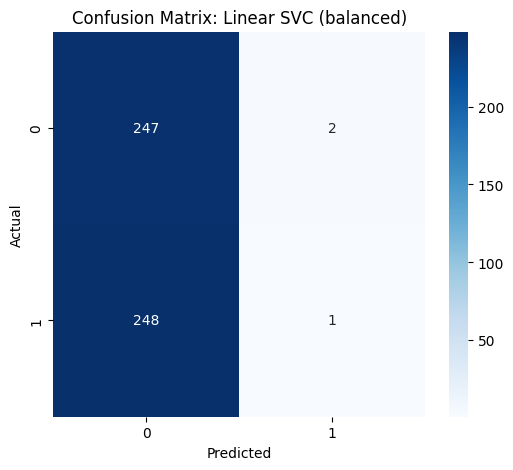


📋 Classification Report: Linear SVC (balanced)
              precision    recall  f1-score   support

           0       0.50      0.99      0.66       249
           1       0.33      0.00      0.01       249

    accuracy                           0.50       498
   macro avg       0.42      0.50      0.34       498
weighted avg       0.42      0.50      0.34       498


✅ Модель и scaler сохранены в: /content/drive/MyDrive/K_means/texts_for_classificator/split//models


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


base_path = "/content/drive/MyDrive/K_means/texts_for_classificator/split/"
train_csv = f"{base_path}/hdbscan_train.csv"
test_csv = f"{base_path}/hdbscan_test.csv"
model_output_path = f"{base_path}/models"
os.makedirs(model_output_path, exist_ok=True)

# === Загрузка данных ===
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)


drop_cols = ["bot", "source_bot", "filename"]  # Убираем только метки классов
feature_cols = feature_cols = [
    "total_clusters"
]
# selected_features = ['min_inter']
feature_cols = [col for col in train_df.columns if col not in drop_cols]
X_train = train_df[feature_cols].values
y_train = train_df["bot"].values
X_test = test_df[feature_cols].values
y_test = test_df["bot"].values

# === Масштабирование ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Классификаторы ===
models = {
    "Linear SVC (balanced)": LinearSVC(max_iter=10000, class_weight="balanced"),
    "SVM (RBF, balanced)": SVC(kernel="rbf", class_weight="balanced"),
    "Decision Tree (balanced)": DecisionTreeClassifier(class_weight="balanced"),
    "Random Forest (balanced)": RandomForestClassifier(class_weight="balanced")
}

results = []
predictions = {}
trained_models = {}

# === Кросс-валидация ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    acc_scores = []
    f1_scores = []

    print(f"\n📌 Модель: {name}")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train), 1):
        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_fold_train, y_fold_train)
        y_val_pred = model.predict(X_fold_val)

        acc_scores.append(accuracy_score(y_fold_val, y_val_pred))
        f1_scores.append(f1_score(y_fold_val, y_val_pred))

        print(f"Фолд {fold}: Accuracy = {acc_scores[-1]:.3f}, F1 = {f1_scores[-1]:.3f}")

    # Обучаем на всей обучающей выборке
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    y_test_pred = model.predict(X_test_scaled)
    predictions[name] = y_test_pred

    results.append({
        "Model": name,
        "CV Accuracy": np.mean(acc_scores),
        "CV F1 Score": np.mean(f1_scores),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Test F1 Score": f1_score(y_test, y_test_pred),
        "Precision (Bot)": classification_report(y_test, y_test_pred, output_dict=True)["1"]["precision"],
        "Recall (Bot)": classification_report(y_test, y_test_pred, output_dict=True)["1"]["recall"]
    })

# === Результаты ===
results_df = pd.DataFrame(results).sort_values(by="Test F1 Score", ascending=False)
print("\n📊 Сравнение моделей:")
print(results_df)

# === Матрица ошибок для лучшей модели ===
best_model_name = results_df.iloc[0]["Model"]
best_model = trained_models[best_model_name]
y_best = predictions[best_model_name]

conf_matrix = confusion_matrix(y_test, y_best)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix: {best_model_name}")
plt.show()

print(f"\n📋 Classification Report: {best_model_name}")
print(classification_report(y_test, y_best))

# === Сохранение лучшей модели ===
model_path = os.path.join(model_output_path, f"best_model_cv_{best_model_name.replace(' ', '_').lower()}.pkl")
scaler_path = os.path.join(model_output_path, "scaler.pkl")
joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"\n✅ Модель и scaler сохранены в: {model_output_path}")


## Визуализация плотности данных vs канонические данные для HDBSCAN

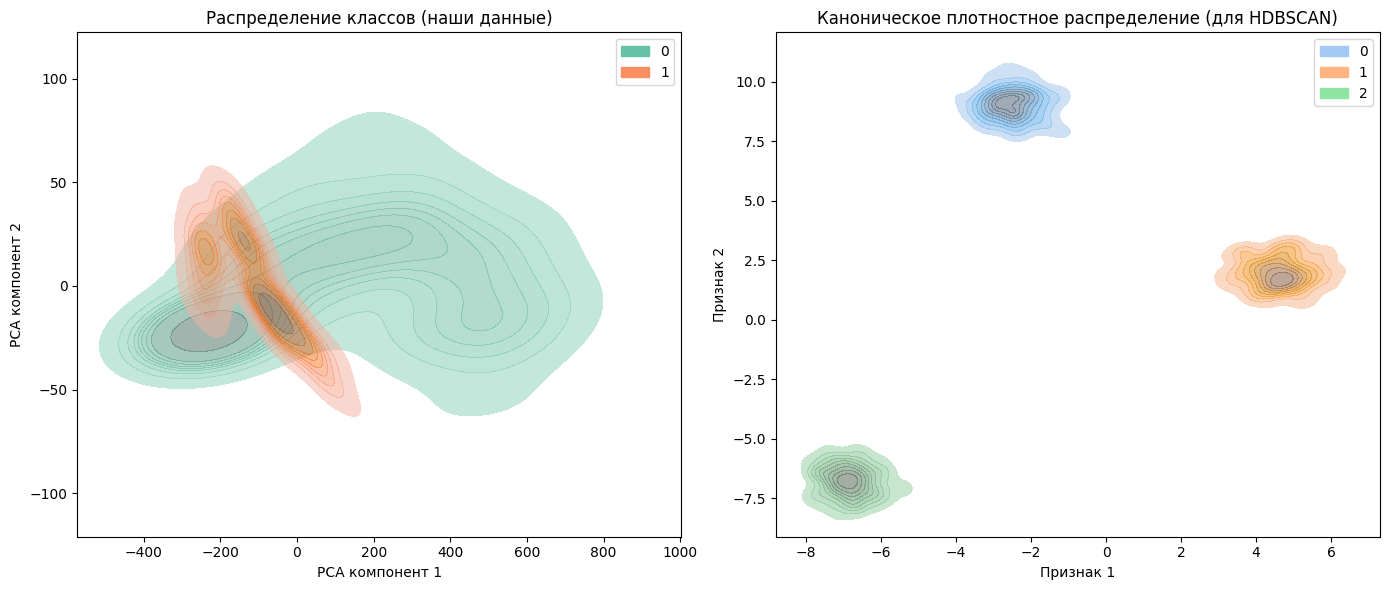

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

# === Загрузка своей выборки ===
df = pd.read_csv("/content/drive/MyDrive/K_means/texts_for_classificator/split/hdbscan_train.csv")

# === Предобработка ===
numeric_cols = df.select_dtypes(include=[np.number]).columns
feature_cols = [col for col in numeric_cols if col != "bot"]
X = df[feature_cols].values
y = df["bot"].values

# === Снижение размерности PCA до 2D ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# === Канонические плотные данные ===
X_blob, y_blob = make_blobs(n_samples=500, centers=3, cluster_std=0.6, random_state=42)

# === Построение графиков ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Плотность из текстовых данных
sns.kdeplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=y,
    fill=True, common_norm=False, alpha=0.5, palette="Set2", ax=axes[0]
)
axes[0].set_title("Распределение классов (наши данные)")
axes[0].set_xlabel("PCA компонент 1")
axes[0].set_ylabel("PCA компонент 2")

# Плотность из make_blobs
sns.kdeplot(
    x=X_blob[:, 0], y=X_blob[:, 1], hue=y_blob,
    fill=True, common_norm=False, alpha=0.5, palette="pastel", ax=axes[1]
)
axes[1].set_title("Каноническое плотностное распределение (для HDBSCAN)")
axes[1].set_xlabel("Признак 1")
axes[1].set_ylabel("Признак 2")

plt.tight_layout()
plt.show()
